In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from math import floor
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [29]:
stock = yf.download('TIINDIA.BO',start ='2022-08-17',end = '2022-09-17' , interval = "5m") #enter the ticker symbol of the the stock you want to analyse
stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-08-17 09:15:00+05:30,2228.100098,2234.550049,2220.199951,2225.000000,2225.000000,477
2022-08-17 09:20:00+05:30,2226.550049,2237.750000,2226.149902,2237.750000,2237.750000,469
2022-08-17 09:25:00+05:30,2237.750000,2238.250000,2230.250000,2230.250000,2230.250000,273
2022-08-17 09:30:00+05:30,2229.350098,2229.350098,2225.750000,2227.350098,2227.350098,73
2022-08-17 09:35:00+05:30,2229.300049,2235.550049,2229.300049,2235.000000,2235.000000,215
...,...,...,...,...,...,...
2022-09-16 15:05:00+05:30,2559.300049,2579.300049,2559.050049,2579.300049,2579.300049,1316
2022-09-16 15:10:00+05:30,2574.500000,2591.750000,2566.000000,2581.550049,2581.550049,1140
2022-09-16 15:15:00+05:30,2566.649902,2577.350098,2564.649902,2564.649902,2564.649902,158


In [30]:
def get_supertrend(high, low, close, lookback, multiplier):
    
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(0)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(0)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(0)
            dt.append(0)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    return st, upt, dt
stock['st1'], stock['s_upt1'], stock['st_dt1'] = get_supertrend(stock['High'], stock['Low'], stock['Close'], 10, 3)
stock['st2'], stock['s_upt2'], stock['st_dt2'] = get_supertrend(stock['High'], stock['Low'], stock['Close'], 20, 5)
stock = stock[1:]
print(stock.head())


                                  Open         High          Low        Close  \
Datetime                                                                        
2022-08-17 09:20:00+05:30  2226.550049  2237.750000  2226.149902  2237.750000   
2022-08-17 09:25:00+05:30  2237.750000  2238.250000  2230.250000  2230.250000   
2022-08-17 09:30:00+05:30  2229.350098  2229.350098  2225.750000  2227.350098   
2022-08-17 09:35:00+05:30  2229.300049  2235.550049  2229.300049  2235.000000   
2022-08-17 09:40:00+05:30  2234.649902  2234.649902  2229.350098  2230.850098   

                             Adj Close  Volume          st1  s_upt1  \
Datetime                                                              
2022-08-17 09:20:00+05:30  2237.750000     469  2272.485805     0.0   
2022-08-17 09:25:00+05:30  2230.250000     273  2268.741025     0.0   
2022-08-17 09:30:00+05:30  2227.350098      73  2256.021023     0.0   
2022-08-17 09:35:00+05:30  2235.000000     215  2256.021023     0.0   
2022-0

In [31]:
def implement_st_strategy(prices, st1,st2,s_upt2,st_dt2):
    buy_price = []
    buy = []
    sell_price = []
    sell = []
    st_signal = []
    signal = 0
    count_buy = 0
    count_sell = 0
    for i in range(len(st1)):
        if st2[i] == s_upt2[i] and (st1[i-1] > prices[i-1] and st1[i] < prices[i]):
            if signal != 1:
                buy_price.append(prices[i])
                buy.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                st_signal.append(signal)
                count_buy = count_buy + 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        elif st2[i] == st_dt2[i] and (st1[i-1] < prices[i-1] and st1[i] > prices[i] ):
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                sell.append(prices[i])
                signal = -1
                st_signal.append(signal)
                count_sell = count_sell  + 1
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                st_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            st_signal.append(0)
            
    return buy_price, sell_price, st_signal, buy, sell,count_buy,count_sell

buy_price, sell_price, st_signal, buy, sell,count_buy,count_sell = implement_st_strategy(stock['Close'], stock['st1'],stock['st2'],stock['s_upt2'],stock['st_dt2'])

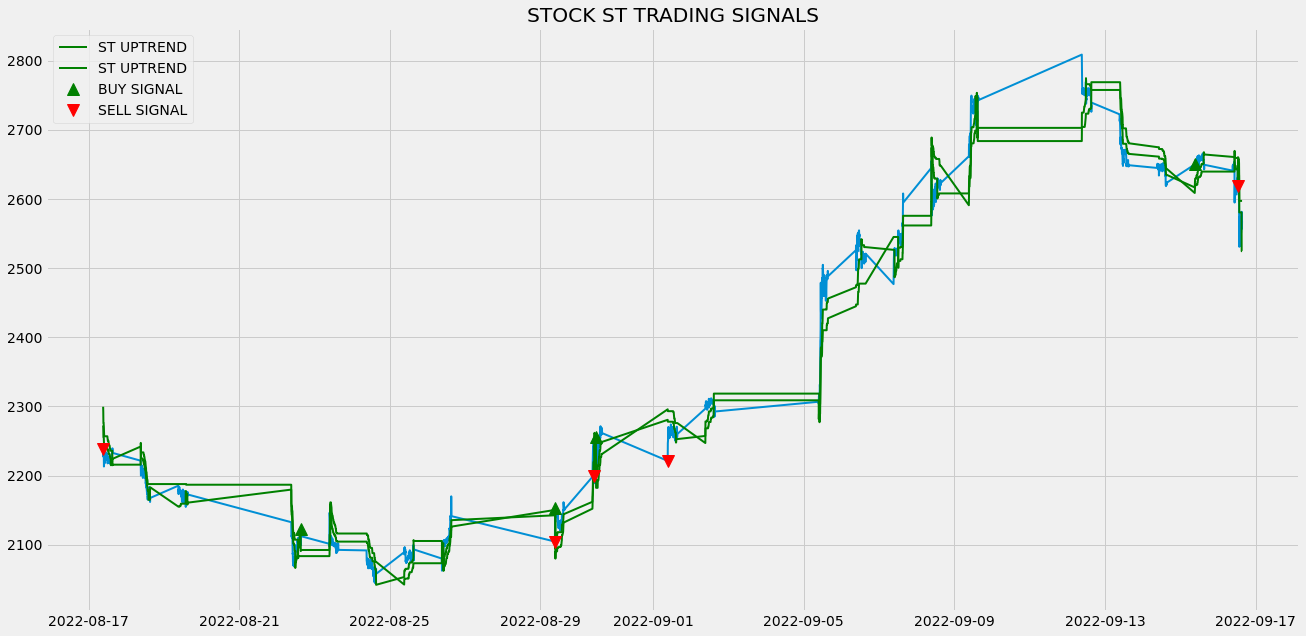

In [32]:
# SUPERTREND SIGNALS

plt.plot(stock['Close'], linewidth = 2)
plt.plot(stock['st1'], color = 'green', linewidth = 2, label = 'ST UPTREND')
plt.plot(stock['st2'], color = 'green', linewidth = 2, label = 'ST UPTREND')
plt.plot(stock.index, buy_price, marker = '^', color = 'green', markersize = 12, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(stock.index, sell_price, marker = 'v', color = 'r', markersize = 12, linewidth = 0, label = 'SELL SIGNAL')
plt.title('STOCK ST TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

In [33]:
# BACKTESTING
prof = []
loss = []
if(len(buy)>=len(sell)):
    for i in range(len(sell)):
        if(buy[i]>sell[i]):
            prof = prof + [buy[i]-sell[i]]
        else:
            loss = loss + [buy[i]-sell[i]]
    print(prof)
    print(loss)
    win_per = (len(prof)/len(sell))*100
    loss_per = (len(loss)/len(sell))*100
    net_prof = 0
    for i in range(len(sell)):
        net_prof = net_prof + buy[i]-sell[i]
    tot_prof = 0 
    tot_loss = 0
    for i in range(len(prof)):
        tot_prof = tot_prof + prof[i]
    for i in range(len(loss)):
        tot_loss = tot_loss + loss[i]
else  :
    for i in range(len(buy)):
        if(buy[i]>sell[i]):
            prof = prof + [buy[i]-sell[i]]
        else:
            loss = loss + [buy[i]-sell[i]]
    print(prof)
    print(loss)
    win_per = (len(prof)/len(buy))*100
    loss_per = (len(loss)/len(buy))*100
    net_prof = 0
    for i in range(len(buy)):
        net_prof = net_prof + buy[i]-sell[i]
    tot_prof = 0 
    tot_loss = 0
    for i in range(len(prof)):
        tot_prof = tot_prof + prof[i]
    for i in range(len(loss)):
        tot_loss = tot_loss + loss[i]
print("net_prof = {}   win_per = {}  loss_per = {}  win/loss ratio ={}    total profit in winning trades = {}    total loss in loosing trades = {}".format(net_prof,win_per,loss_per,len(prof)/len(loss),tot_prof,tot_loss))

[48.2001953125, 55.050048828125, 428.699951171875]
[-114.39990234375]
net_prof = 417.55029296875   win_per = 75.0  loss_per = 25.0  win/loss ratio =3.0    total profit in winning trades = 531.9501953125    total loss in loosing trades = -114.39990234375
